### HOUSE PREDICTION AND HYPERPARAMETER TUNING

**Project Goal**: Using data from the [Geo Data and Lab](https://geodacenter.github.io/data-and-lab/KingCounty-HouseSales2015/) website to predict the housing prices using Random Forest Regression and fine-tune its hyperparameters so as to improve the model performance. 

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [35]:
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


**Exploratory Data Analysis**

In [36]:
print(f"The dataset contains {df.shape[0]} samples and " f"{df.shape[1]} features")

The dataset contains 21613 samples and 21 features


In [37]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

- We drop the id and date column from our data as they will not be useful for prediction excercise. We also seperate the target variable from the predictor vaariables.

In [38]:
X = df.drop(["id", "price", "date"], axis = 1)
y = df["price"]

- Next step is to pick out categorical variables from numerical variables using column selection from sklearn's compose.

In [39]:
from sklearn.compose import make_column_selector as selector

categorical_column_selector = selector(dtype_include=object)
categorical_columns = categorical_column_selector(X)
categorical_columns

[]

In [40]:
# Identifyingg the numerical variables.

num_vars = [var for var in X.columns if var not in categorical_columns]

# Number of numerical variables
print(len(num_vars))
print(num_vars)

18
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


- Note: Some categorical variables are numerical variables and we put them into their correct list.

In [41]:
# List of discrete variables
categorical_vars = [var for var in num_vars if len(X[var].unique()) < 20]

print("Number of categorical variables: ", len(categorical_vars))
print(categorical_vars)

Number of categorical variables:  6
['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']


In [42]:
# Visualizing the categorical variables.

X[categorical_vars].head()

,bedrooms,floors,waterfront,view,condition,grade
0,3,1.0,0,0,3,7
1,3,2.0,0,0,3,7
2,2,1.0,0,0,3,6
3,4,1.0,0,0,5,7
4,3,1.0,0,0,3,8


- The remaining numerical variables will now be classified as continuous variables.

In [43]:
#A list of continuous variables.
cont_vars = [var for var in num_vars if var not in categorical_vars]

print("Number of continuous variables: ", len(cont_vars))
print(cont_vars)

Number of continuous variables:  12
['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [44]:
# Visualize the continuous variables
X[cont_vars].head()

,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1.00,1180,5650,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2.25,2570,7242,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,1.00,770,10000,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3.00,1960,5000,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2.00,1680,8080,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


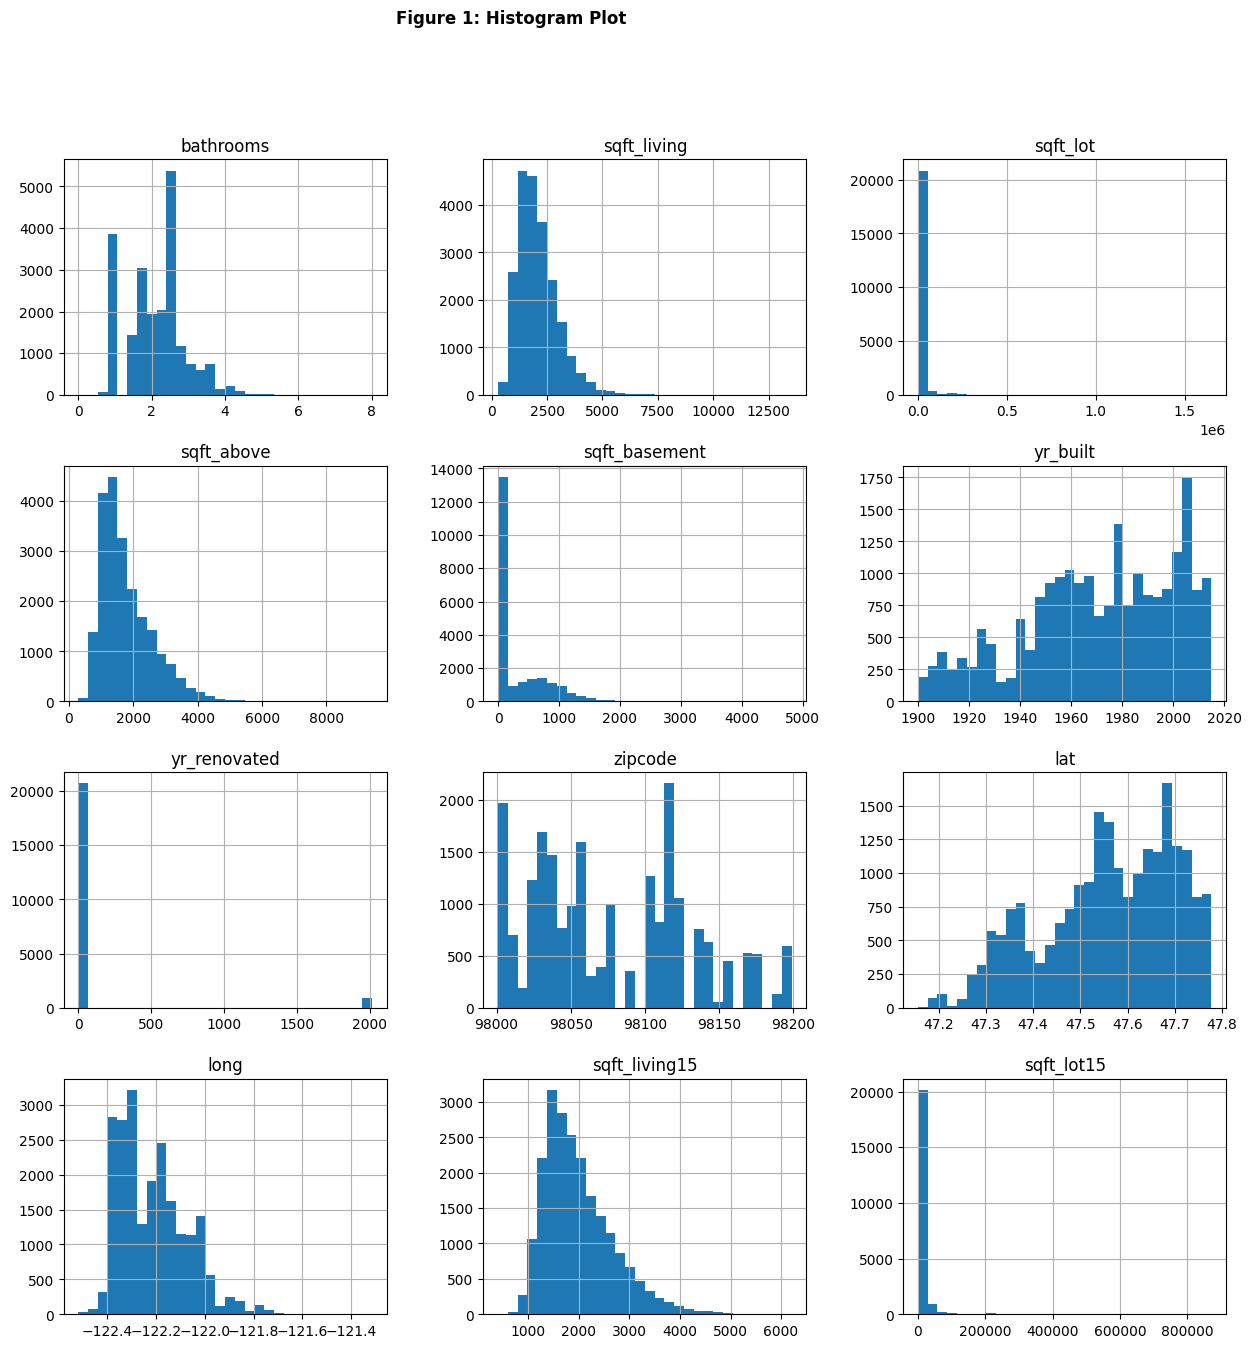

In [45]:
# Visualizing variable distribution using hsitogram

X[cont_vars].hist(bins=30, figsize=(15, 15))
plt.suptitle("Figure 1: Histogram Plot", fontweight="bold", horizontalalignment="right")
plt.show()

**Modeling Pipeline**

In [46]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [47]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_vars),
        ("standard_scaler", numerical_preprocessor, cont_vars),
    ]
)

Pipeline for a regression model:

In [48]:
model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]
)

In [49]:
from sklearn import set_config

set_config(display="diagram")
model 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['bedrooms', 'floors',
                                                   'waterfront', 'view',
                                                   'condition', 'grade']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['bathrooms', 'sqft_living',
                                                   'sqft_lot', 'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'yr_renovated', 'zipcode',
                                                   'lat', 'long',
                                                   'sqft_living15',
                                                   'sqft_lot15'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [50]:
# Seperating data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictive variables
    y,  # target
    test_size=0.3,  # portion of dataset to allocate to test set
    random_state=0,  # we are setting the seed here
)

X_train.shape, X_test.shape

((15129, 18), (6484, 18))

- The output below reveals that the target variable is skewed to the left and our model will have a tendency to predict values to the most common value. Therefore, we transform it to make it normal. 

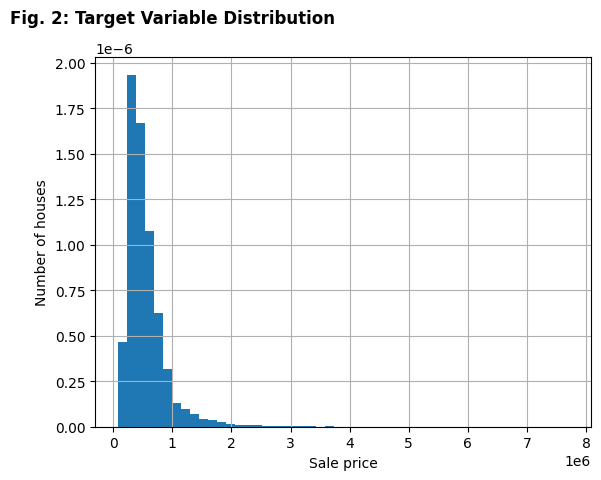

In [51]:
# histogram to evaluate target distribution

df["price"].hist(bins=50, density=True)
plt.ylabel("Number of houses")
plt.xlabel("Sale price")
plt.suptitle(
    "Fig. 2: Target Variable Distribution",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

- After log transforming the target variable, it now looks more normally distributed and will therefore use log transform variables as our target.

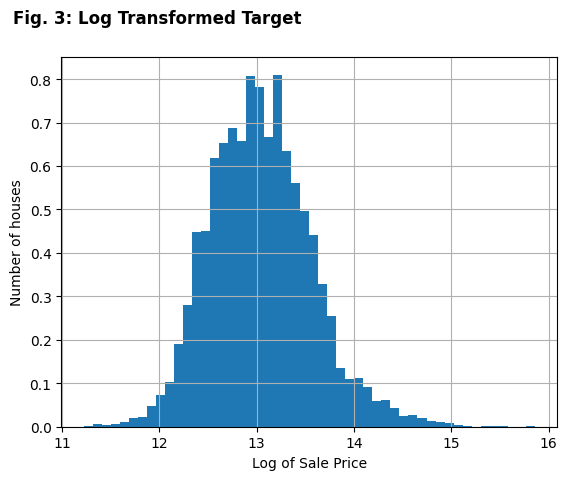

In [52]:
# transform the target variable using the logarithm 



np.log(df["price"]).hist(bins=50, density=True)
plt.ylabel("Number of houses")
plt.xlabel("Log of Sale Price")
plt.suptitle(
    "Fig. 3: Log Transformed Target", fontweight="bold", horizontalalignment="right"
)
plt.show()

In [53]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [54]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1468,4,1.50,1390,7200,1.0,0,0,3,7,1140,250,1965,0,98133,47.7224,-122.332,1630,7702
15590,3,1.50,1450,7316,1.0,0,0,3,7,1450,0,1961,0,98133,47.7725,-122.349,1440,7316
18552,5,2.75,2860,5379,2.0,0,0,3,9,2860,0,2005,0,98052,47.7082,-122.104,2980,6018
10535,2,1.00,1050,4125,1.0,0,0,4,7,1050,0,1909,0,98144,47.5736,-122.307,1650,4125
1069,2,1.00,1240,57000,1.0,0,0,3,7,1240,0,1962,0,98075,47.5970,-122.059,3050,25545


In [55]:
_ = model.fit(X_train, y_train)

In [56]:
X_test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17384,2,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
722,4,3.25,4670,51836,2.0,0,0,4,12,4670,0,1988,0,98005,47.6350,-122.164,4230,41075
2680,2,0.75,1440,3700,1.0,0,0,3,7,1200,240,1914,0,98107,47.6707,-122.364,1440,4300
18754,2,1.00,1130,2640,1.0,0,0,4,8,1130,0,1927,0,98109,47.6438,-122.357,1680,3200
14554,4,2.50,3180,9603,2.0,0,2,3,9,3180,0,2002,0,98155,47.7717,-122.277,2440,15261


In [57]:
target_predicted = model.predict(X_test)

print(
    f"Mean squared error on the testing set: "
    f"{mean_squared_error(y_test, target_predicted):.3f}"
)

Mean squared error on the testing set: 0.031


**Regression Metrics**

In [58]:
model.score(X_test, y_test)

0.8881564227963746

- Model performance is good. Well now test to see if we can improve this performance using hyperparameter tuning.